In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [9]:
df = pd.read_csv('fraudTrain.csv')
df.head(), df.shape
df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [11]:
print(df.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


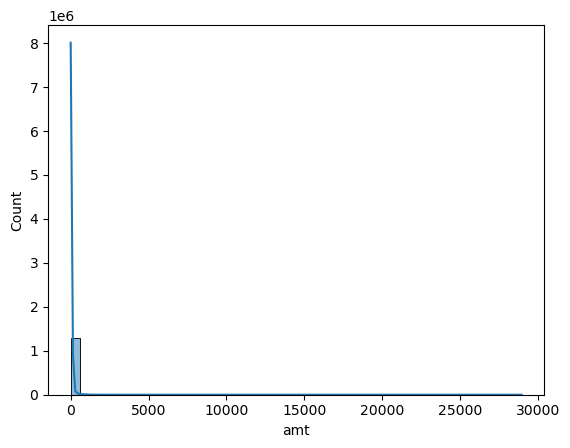

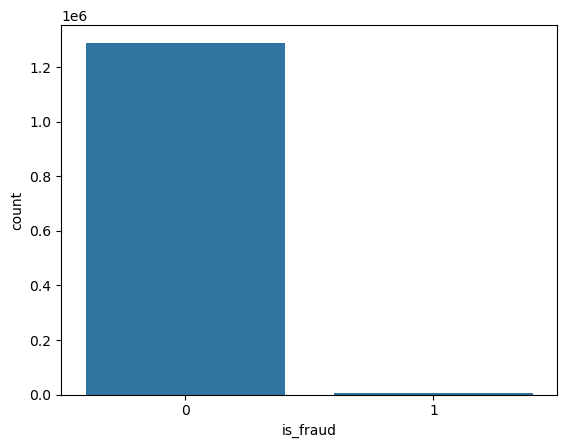

In [13]:
sns.histplot(df["amt"], bins=50, kde=True)
plt.show()
sns.countplot(x="is_fraud", data=df)
plt.show()

In [15]:
X = df.drop("is_fraud", axis=1).copy()
y = df["is_fraud"]

X['trans_date_trans_time'] = pd.to_datetime(X['trans_date_trans_time'])
X['year'] = X['trans_date_trans_time'].dt.year
X['month'] = X['trans_date_trans_time'].dt.month
X['day'] = X['trans_date_trans_time'].dt.day
X['hour'] = X['trans_date_trans_time'].dt.hour
X['minute'] = X['trans_date_trans_time'].dt.minute
X['second'] = X['trans_date_trans_time'].dt.second
X = X.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [17]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [19]:
log = LogisticRegression(class_weight="balanced", max_iter=1000)
log.fit(X_train_res, y_train_res)
y_pred = log.predict(X_test)
log_proba = log.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, log_proba))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97    386751
           1       0.09      0.77      0.15      2252

    accuracy                           0.95    389003
   macro avg       0.54      0.86      0.56    389003
weighted avg       0.99      0.95      0.97    389003

ROC AUC: 0.8374656167468245


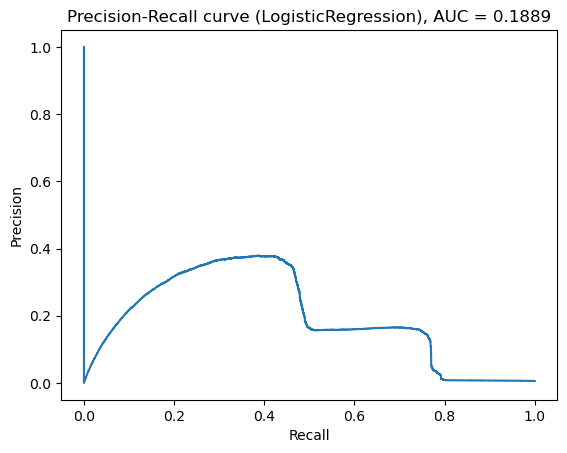

In [31]:
log_precision, log_recall, log_thresholds = precision_recall_curve(y_test, log_proba)
log_pr_auc = auc(log_recall, log_precision)
plt.plot(log_recall, log_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (LogisticRegression), AUC = {:.4f}".format(log_pr_auc))
plt.show()

In [23]:
dec = DecisionTreeClassifier(class_weight="balanced", random_state=42)
dec.fit(X_train_res, y_train_res)
y_pred_dec = dec.predict(X_test)
dec_proba = dec.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_dec))
print("ROC AUC (DecisionTreeClassifier):", roc_auc_score(y_test, dec_proba))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98    386751
           1       0.09      0.66      0.16      2252

    accuracy                           0.96    389003
   macro avg       0.54      0.81      0.57    389003
weighted avg       0.99      0.96      0.97    389003

ROC AUC (DecisionTreeClassifier): 0.8085539199075188


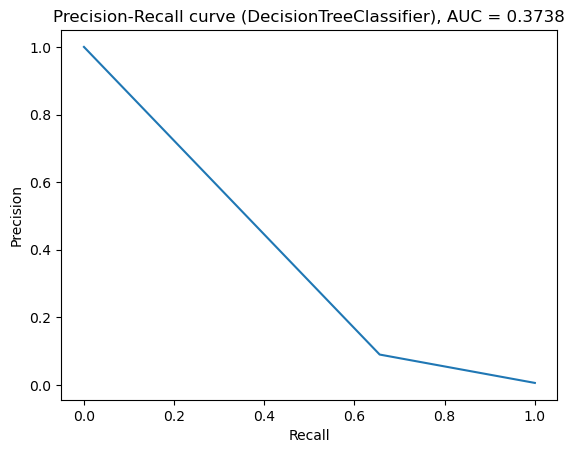

In [25]:
dec_precision, dec_recall, dec_thresholds = precision_recall_curve(y_test, dec_proba)
dec_pr_auc = auc(dec_recall, dec_precision)
plt.plot(dec_recall, dec_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (DecisionTreeClassifier), AUC = {:.4f}".format(dec_pr_auc))
plt.show()

In [27]:
ran = RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42)
ran.fit(X_train_res, y_train_res)
y_pred_ran = ran.predict(X_test)
ran_proba = ran.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_ran))
print("ROC AUC (RandomForestClassifier):", roc_auc_score(y_test, ran_proba))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    386751
           1       0.27      0.70      0.39      2252

    accuracy                           0.99    389003
   macro avg       0.64      0.84      0.69    389003
weighted avg       0.99      0.99      0.99    389003

ROC AUC (RandomForestClassifier): 0.9650546427416894


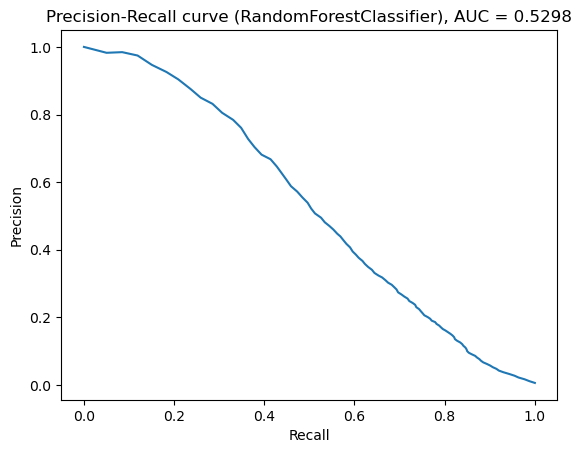

In [28]:
ran_precision, ran_recall, ran_thresholds = precision_recall_curve(y_test, ran_proba)
ran_pr_auc = auc(ran_recall, ran_precision)
plt.plot(ran_recall, ran_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (RandomForestClassifier), AUC = {:.4f}".format(ran_pr_auc))
plt.show()


In [33]:
def predict_fraud(transaction_data, model, threshold=0.5):
    
    df_single = pd.DataFrame([transaction_data])

    df_single['trans_date_trans_time'] = pd.to_datetime(df_single['trans_date_trans_time'])
    df_single['year'] = df_single['trans_date_trans_time'].dt.year
    df_single['month'] = df_single['trans_date_trans_time'].dt.month
    df_single['day'] = df_single['trans_date_trans_time'].dt.day
    df_single['hour'] = df_single['trans_date_trans_time'].dt.hour
    df_single['minute'] = df_single['trans_date_trans_time'].dt.minute
    df_single['second'] = df_single['trans_date_trans_time'].dt.second

    df_single = df_single.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num'], axis=1)

    training_columns = X_train_res.columns.tolist() 
    df_single = df_single[training_columns]

    fraud_probability = model.predict_proba(df_single)[:, 1][0]

    predicted_class = 1 if fraud_probability > threshold else 0

    return fraud_probability, predicted_class

sample_transaction = {
    'Unnamed: 0': 0,
    'trans_date_trans_time': '2019-01-01 00:00:18', 
    'cc_num': 'fake_cc_num',
    'merchant': 'fake_merchant',
    'category': 'fake_category',
    'amt': 100.00,
    'first': 'fake_first',
    'last': 'fake_last',
    'gender': 'M',
    'street': 'fake_street',
    'city': 'fake_city',
    'state': 'fake_state',
    'zip': 12345,
    'lat': 36.0788,
    'long': -81.1781,
    'city_pop': 3495,
    'job': 'fake_job',
    'dob': 'fake_dob',
    'trans_num': 'fake_trans_num',
    'unix_time': 1325376018,
    'merch_lat': 36.011293,
    'merch_long': -82.048315,
}

probability, prediction = predict_fraud(sample_transaction, log)
print("Logistic Regression")
print(f"data:{sample_transaction}")
print(f"Probability of fraud: {probability:.4f}")
print(f"Predicted class: {'Fraud' if prediction == 1 else 'Not Fraud'}")

probability, prediction = predict_fraud(sample_transaction, dec)
print("Decision Tree")
print(f"data:{sample_transaction}")
print(f"Probability of fraud: {probability:.4f}")
print(f"Predicted class: {'Fraud' if prediction == 1 else 'Not Fraud'}")

probability, prediction = predict_fraud(sample_transaction, ran)
print("Random Forest")
print(f"data:{sample_transaction}")
print(f"Probability of fraud: {probability:.4f}")
print(f"Predicted class: {'Fraud' if prediction == 1 else 'Not Fraud'}")

Logistic Regression
data:{'Unnamed: 0': 0, 'trans_date_trans_time': '2019-01-01 00:00:18', 'cc_num': 'fake_cc_num', 'merchant': 'fake_merchant', 'category': 'fake_category', 'amt': 100.0, 'first': 'fake_first', 'last': 'fake_last', 'gender': 'M', 'street': 'fake_street', 'city': 'fake_city', 'state': 'fake_state', 'zip': 12345, 'lat': 36.0788, 'long': -81.1781, 'city_pop': 3495, 'job': 'fake_job', 'dob': 'fake_dob', 'trans_num': 'fake_trans_num', 'unix_time': 1325376018, 'merch_lat': 36.011293, 'merch_long': -82.048315}
Probability of fraud: 0.2951
Predicted class: Not Fraud
Decision Tree
data:{'Unnamed: 0': 0, 'trans_date_trans_time': '2019-01-01 00:00:18', 'cc_num': 'fake_cc_num', 'merchant': 'fake_merchant', 'category': 'fake_category', 'amt': 100.0, 'first': 'fake_first', 'last': 'fake_last', 'gender': 'M', 'street': 'fake_street', 'city': 'fake_city', 'state': 'fake_state', 'zip': 12345, 'lat': 36.0788, 'long': -81.1781, 'city_pop': 3495, 'job': 'fake_job', 'dob': 'fake_dob', 'tra